# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from matplotlib import rcParams
from sklearn.metrics import confusion_matrix
from IPython.display import Image 
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from sklearn.grid_search import GridSearchCV
import pydotplus 
import StringIO
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Zhang, Christine]

### Part (b): Course Number

[CS 109a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.

We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [2]:
#Load the data from satellite image #1 
sat_img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
#Check out the data - sanity check
sat_img_1.head()

0         1    2
0  0.566809  0.788130  1.0
1  0.400046  0.620933  1.0
2  0.458702  0.536935  1.0
3  0.474504  0.638224  1.0
4  0.558707  0.715527  1.0

In [3]:
#The data looks ok, so let's load the rest of the images
sat_img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
sat_img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
sat_img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)

#Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

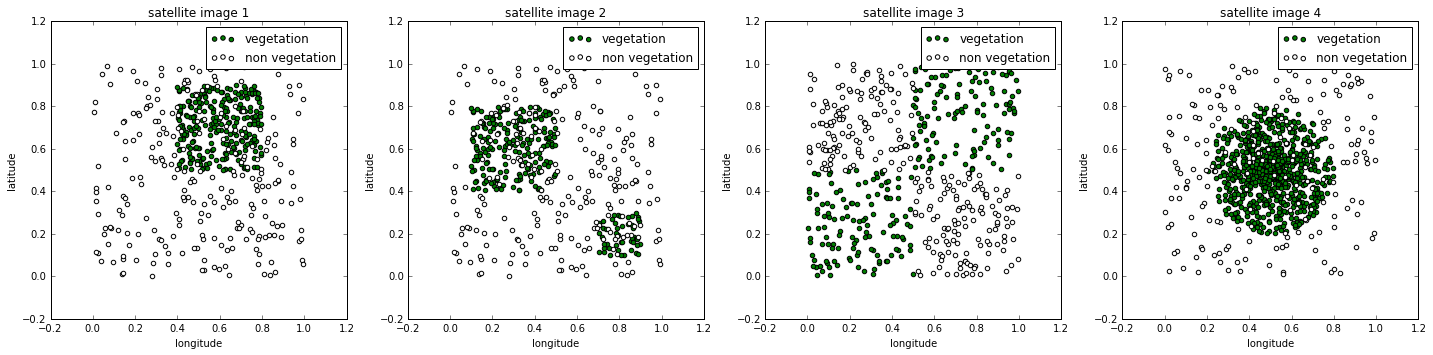

In [4]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show() 

For each image, based on the sample of we want to train a classifier that will classify a location as vegetation or non-vegetation.
Since the vegetation seem to be clustered in isolated regions in each image. Classifying locations with vegetation involves learning a boundary around each region. We then classify the points inside this region as vegetation and points outside as non-vegetation.
The vegetation regions in an image can be identified by treating the latitude and longitude values as predictors and the vegetation information as a binary response, and fitting a classification model. The decision boundaries of these classifiers then allow us to identify the vegetation regions. From inspection, I predict that for the square vegtation boundaries, we will need enough decision tree lines (4) to firmly outline all of the border lines. 

In [5]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

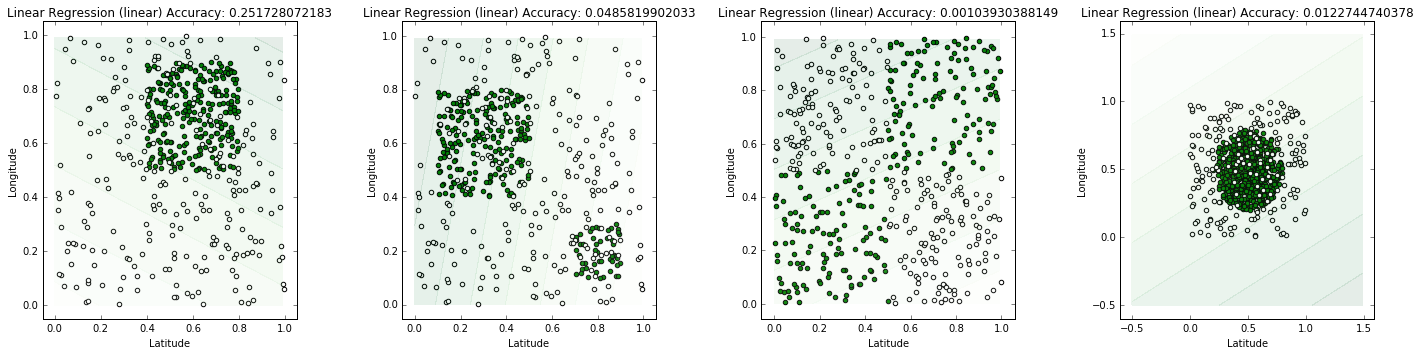

In [9]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a linear regression model with linear boundary
linreg = linear_model.LinearRegression()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]    
    
    #Fit our linear regression model
    linreg.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
        
    score = linreg.score(x,y)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, linreg, 
                                   'Linear Regression (linear) Accuracy: ' + str(score), 
                                   ax[i], bounds)
    

plt.tight_layout()
plt.show()

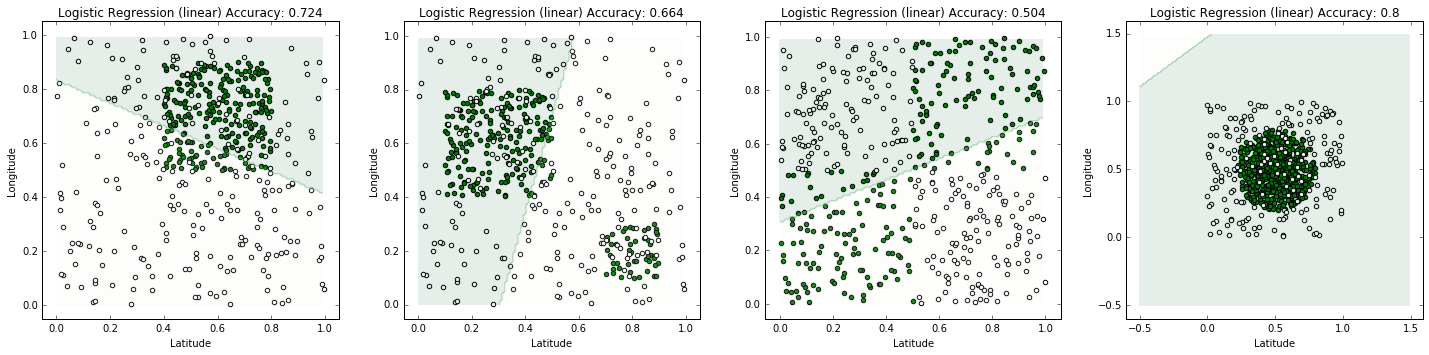

In [10]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]    
    
    #Fit our logistic regression model
    logreg.fit(x, y)
    score = logreg.score(x,y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg, 
                                   'Logistic Regression (linear) Accuracy: ' + str(score), 
                                   ax[i], bounds)
    

plt.tight_layout()
plt.show()

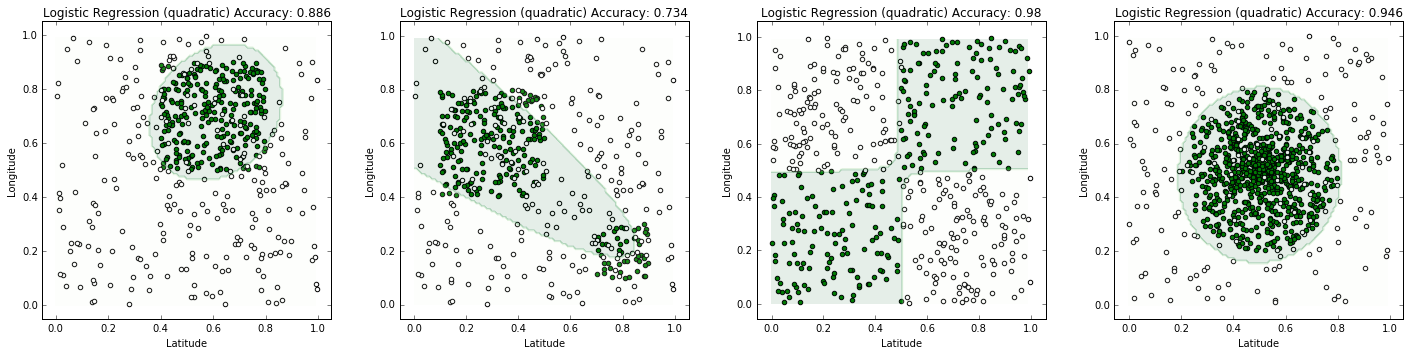

In [15]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    score = logreg_poly.score(x_expanded, y)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic) Accuracy: ' + str(score), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

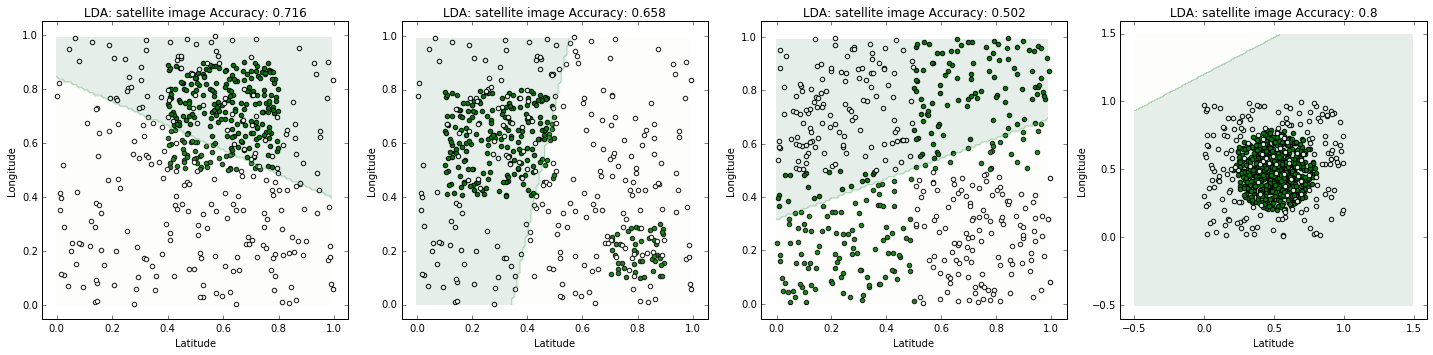

In [13]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our LDA model
    lda.fit(x, y)
    score = lda.score(x,y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
        
    #Plot the data along with the decision boundary learned by our model    
    ax[i] = plot_decision_boundary(x, y, lda, 'LDA: satellite image Accuracy: ' + str(score), ax[i], bounds)
    

plt.tight_layout()
plt.show()

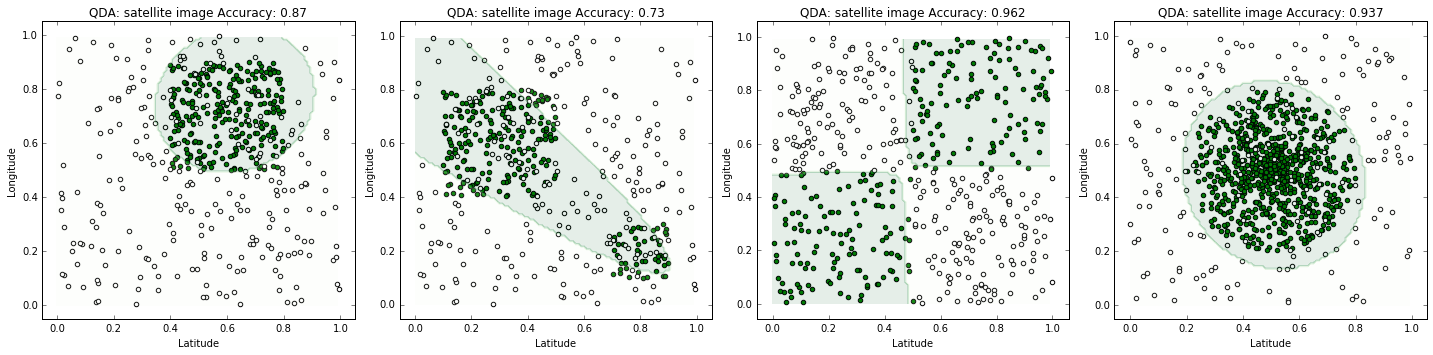

In [14]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    qda.fit(x, y)
    score = qda.score(x,y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, qda, 'QDA: satellite image Accuracy: ' + str(score), ax[i])
    

plt.tight_layout()
plt.show()

The linear regression model does a poor job of predicting the vegetation patterns because it is too limited in scope. It is only one dimensional and makes linear projections that do not capture larger trends such as geometry or multiple clusters of vegetation. A majority of the datapoints are classified incorrectly as the model can only produce a gradient of vegetation incidence likelihood, completely ignoring patterns in vegatation.

Linear logistic regression does a better job than linear regresion but since the predictions are made on a single line, it still performs poorly on multiple clusters or shapes. With the multiple clusters scenario, logistic regression ends up just classifying the largest cluster and ignores outlier vegetation points. With the circle, the round shape threw off the model as it ended up incorrectly classifying all points as vegetation. 

Quadratic logistic regression performed better than linear logistic regression because it was able to better represent clusters or multiple sets of vegetation. However, since it can only be fit to quadratic curves, there are still severe limitations. For satellite image 2, there was no clear way of fitting a quadratic boundary without classifying the points in between. With curved shapes, the quadratic curve is not specific enough to get a close approximation. 

Linear discriminatory analysis performed similiarly to linear logistic regression. The model was not a good fit since it could not capture larger trends such as shapes or clusters. Attempting to fit a linear line to a complex model resulted in the misclassification of many data points and oversimiplication of the dataset. 

Quadratic discriminatory analysis performed similiarly to quadratic logistic regression. It was able to fit the vegetation regions in dataset 4 but was a poor predictor of curved or other clustered datasets. This results because it is difficult to fit a quadratic curve to a variety of data patterns. 

A decision tree may be the best predictor to visualize a variety of vegetation patterns because controlling for the depth of the tree allows you to best reprsent detailed patterns without overfitting to the training set. Decision trees also have the advantage in that since a lot of these vegetation patterns are square, we can make clean lines to delinate the borders of the vegetation regions.

In [11]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [12]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

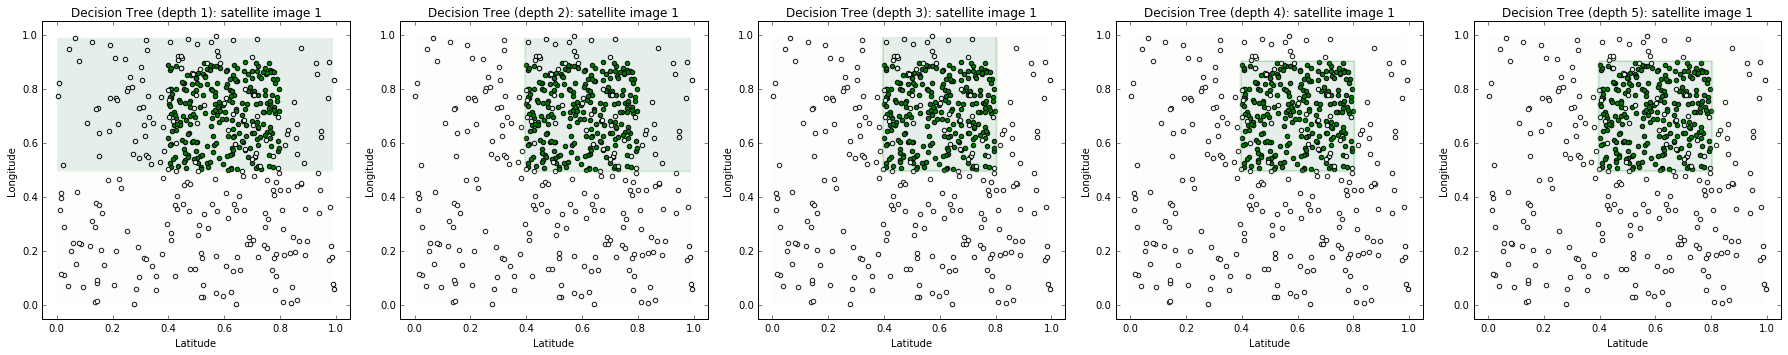

In [13]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[0].values[:, :-1]
#Get the class labels
y = sat_images[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

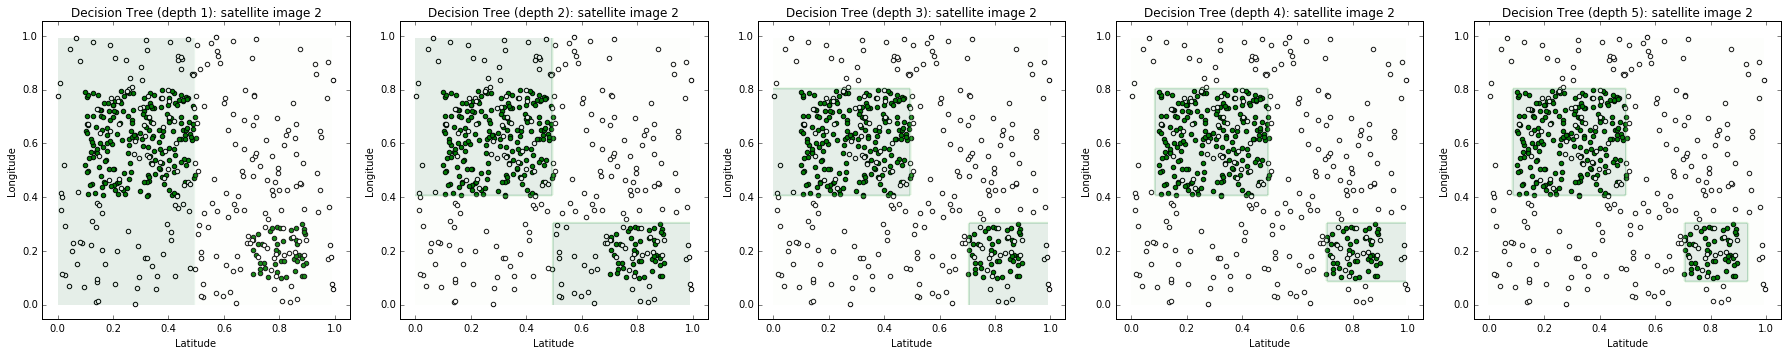

In [14]:
# Plot for dataset_2.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[1].values[:, :-1]
#Get the class labels
y = sat_images[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 2'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

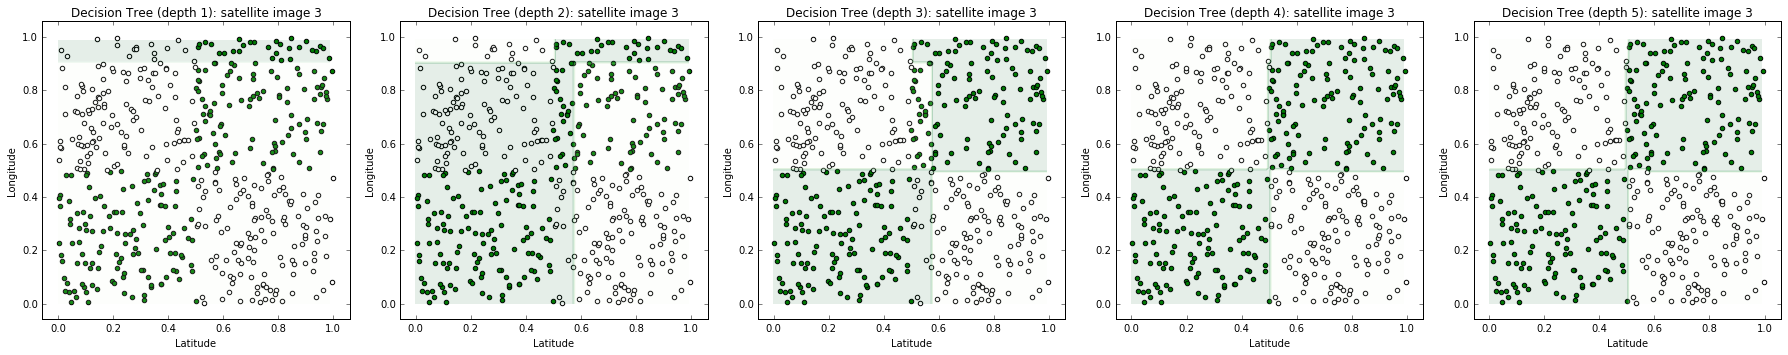

In [15]:
# Plot for dataset_3.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[2].values[:, :-1]
#Get the class labels
y = sat_images[2].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

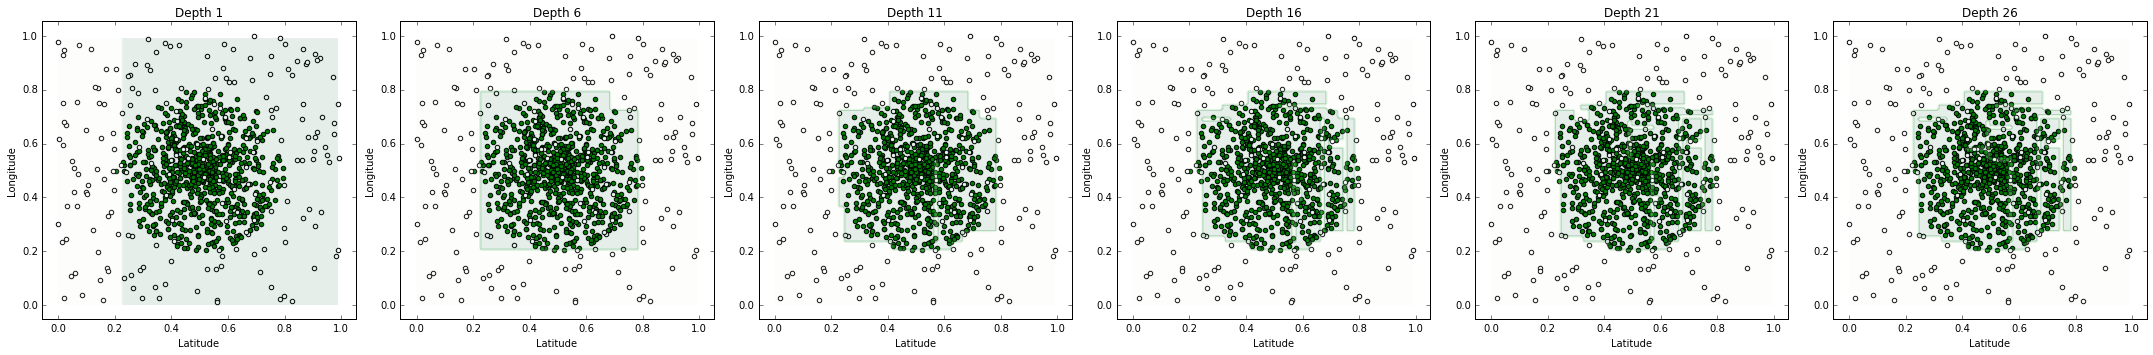

In [16]:
# Plot for dataset_4.txt: depths 1 through 26
fig, ax = plt.subplots(1, len(range(1, 27, 5)), figsize=(30, 5))

#Get the long/lat coords
x = sat_images[3].values[:, :-1]
#Get the class labels
y = sat_images[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 27, 5):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Depth {}'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1
    
plt.tight_layout()
plt.show()

Since the vegetation region in dataset 1 takes the shape of a rectangle, a decision tree with a minimum depth of 4 is needed to define this region: one to check each of left x-limit, right x-limit, lower y-limit and upper y-limit.
The vegetation in dataset 2 spans two rectangles of different sizes, a naive guess would be that we need a decision tree of depth 8, one for each corner of the two rectangles. However it suffices to use a simpler 5-level tree: each rectangle can be captured by a decision tree of depth 4, and the root node branches to one of these trees.
Since the vegetation region in dataset 3 takes the shape of two rectangles lined up along their diagonals. A depth 2 decision tree would have sufficed for this data set. However, due to the greedy nature of the fitting algorithm, we needed to go up to depth 4 to get a good fit. This is due to a sub-optimal local choice at higher depths. A decision tree is a very poor predictor of circular data since it is difficult to round off the corners correctly with horizontal and vertical lines. Since the vegetation is circular in shape, a decision tree with infinite depth is required to fit this data set.

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In [17]:
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*np.log(x1) - x2*np.log(x2)

# Split 1:

# Compute split counts
n11 = 48
n12 = 52
n1 = n11 + n12

# Compute split probabilities
x1 = 11./n11
x2 = 37./n11
y1 = 40./n12
y2 = 12./n12

print('Split 1')
print('Error = ' + str((n11*err(x1,x2)+n12*err(y1,y2))/n1))
print('Gini = ' + str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1))
print('Entropy = ' + str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1))

print('')

# Compute split counts
n21 = 73
n22 = 27
n2 = n21 + n22

# Split 2:
x1 = 25./n21
x2 = 48./n21
y1 = 26./n22
y2 = 1./n22

print('Split 2')
print('Error = ' + str((n21*err(x1,x2)+n22*err(y1,y2))/n2))
print('Gini = ' + str((n21*Gini(x1,x2)+n22*Gini(y1,y2))/n2))
print('Entropy = ' + str((n21*entropy(x1,x2)+n22*entropy(y1,y2))/n2))

Split 1
Error = 0.23
Gini = 0.354198717949
Entropy = 0.539274531592

Split 2
Error = 0.26
Gini = 0.348026382547
Entropy = 0.511910804521


There are three methods of evaluating a split and it is helpful to run all three to obtain a more holistic understanding of the split. Error is a basic measure of the misclassification statistic. Gini is a measure of how frequency a random element would be classified incorrectly if given a random classification based on a distribution unique to the subset of labels. Entropy is a measure of impurity within the dataset so minimizing entropy is another metric we can use to decide decision tree dividers. 

In explaining our options, we see that the error method chose split 1 while both the Gini and Entropy evaluators had lower values for split 2 (0.348 vs 0.354 and 0.512 vs 0.539 respectively).
While Split 1 has lower error, Split 2 is better, as the partitions are purer - the right-hand partition contains an almost perfect classification as there was only one outlier and 26 correctly classified and partioned points.
Gini coefficient and Cross-entropy choose Split 2 over Split 1, showing that they promote purer splits. This shows that these are better criteria are than error, which is why it is a good strategy to check all three metrics before deciding how to proceed with a decision tree. 

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [115]:
# Print decision tree model 'model', already fitted
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io) 
    print dummy_io.getvalue()

In [116]:
# initialize colors for plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [117]:
# assign column names to the imported datasets
column_names = ['Census', 'Credit', 'Gender', 'Education', 'Marital Status', 'Age', 'Repayment 1', 'Repayment 2', 'Repayment 3', 'Repayment 4', 'Repayment 5', 'Repayment 6', 'Bill 1', 'Bill 2', 'Bill 3', 'Bill 4', 'Bill 5', 'Bill 6', 'Previous 1', 'Previous 2', 'Previous 3', 'Previous 4', 'Previous 5', 'Previous 6', 'Result']
loan_train = pd.read_csv('datasets/dataset_5_train.txt', delimiter=',', header=None, names = column_names)
loan_test = pd.read_csv('datasets/dataset_5_test.txt', delimiter=',', header=None, names = column_names)
loan_train.head(n=5)

Census    Credit  Gender  Education  Marital Status   Age  Repayment 1  \
0  3288.0   20000.0     2.0        1.0             2.0  39.0          0.0   
1  3001.0   50000.0     1.0        2.0             2.0  27.0          2.0   
2  3288.0   80000.0     1.0        2.0             2.0  27.0          1.0   
3  3652.0   70000.0     2.0        2.0             2.0  22.0          0.0   
4  3817.0  200000.0     1.0        1.0             2.0  24.0         -1.0   

   Repayment 2  Repayment 3  Repayment 4   ...     Bill 4   Bill 5   Bill 6  \
0          0.0          0.0          0.0   ...    19308.0  19498.0      0.0   
1          2.0          0.0          0.0   ...     7382.0   1975.0  50514.0   
2          2.0          2.0          2.0   ...    68531.0  69808.0  70544.0   
3          0.0          0.0          0.0   ...    69316.0  29083.0  28140.0   
4         -1.0         -1.0         -1.0   ...    18154.0  13677.0   2018.0   

   Previous 1  Previous 2  Previous 3  Previous 4  Previous 5  Previous 6  \
0      1588.0      1770.0      1200.0       390.0         0.0     44334.0   
1      4146.0      1200.0         0.0         0.0     49800.0         0.0   
2      5000.0      3100.0      2000.0      3000.0      2000.0      4000.0   
3      3200.0      3600.0      3075.0      1204.0      1200.0      1046.0   
4       200.0       198.0     18156.0         0.0      1150.0         0.0   

   Result  
0     1.0  
1     1.0  
2     1.0  
3     0.0  
4     0.0  

[5 rows x 25 columns]

In [118]:
# create a function for parsing datasets and implementing one-hot encoding
def onehot(dataset):
    data_1 = dataset.iloc[:, 0]
    data_1_dummies = pd.get_dummies(data_1)
    data_2 = dataset.iloc[:, 1]
    data_3 = dataset.iloc[:, 2]
    data_3_dummies = pd.get_dummies(data_3)
    data_4 = dataset.iloc[:, 3]
    data_4_dummies = pd.get_dummies(data_4)
    data_5 = dataset.iloc[:, 4]
    data_5_dummies = pd.get_dummies(data_5)
    data_6 = dataset.iloc[:, 5:]
    return data_1, data_1_dummies, data_2, data_3, data_3_dummies, data_4, data_4_dummies, data_5, data_5_dummies, data_6

In [119]:
# clean the testing dataset by dropping excess values
data_1, data_1_dummies, data_2, data_3, data_3_dummies, data_4, data_4_dummies, data_5, data_5_dummies, data_6 = onehot(loan_test)

#drop 3381
print 'Census Codes: ', np.unique(data_1)
print 'Gender: ', np.unique(data_3)
#drop 0, 5, 6
print 'Education Status: ', np.unique(data_4)
#drop 0
print 'Marital Status: ', np.unique(data_5)

Census Codes:  [ 3001.  3123.  3288.  3298.  3381.  3420.  3530.  3540.  3585.  3652.
  3662.  3817.  3827.]
Gender:  [ 1.  2.]
Education Status:  [ 0.  1.  2.  3.  4.  5.  6.]
Marital Status:  [ 0.  1.  2.  3.]


In [120]:
# drop mistyped values from the test dataset
loan_test = loan_test[(loan_test['Census'] != 3381.) & 
                      (loan_test['Education'] != 0.) & 
                      (loan_test['Education'] != 5.) & 
                      (loan_test['Education'] != 6.) & 
                      (loan_test['Marital Status'] != 0.)]

# separate out predictors from response variables
x_test = loan_test.iloc[:, :-1]
y_test = loan_test.iloc[:,-1]

# concatenate a one-hot predictor dataset
data_1, data_1_dummies, data_2, data_3, data_3_dummies, data_4, data_4_dummies, data_5, data_5_dummies, data_6 = onehot(x_test)
x_test = pd.concat([data_1_dummies, data_2, data_3_dummies, data_4_dummies, data_5_dummies, data_6], axis = 1)

In [121]:
# clean the training dataset by dropping excess values
data_1, data_1_dummies, data_2, data_3, data_3_dummies, data_4, data_4_dummies, data_5, data_5_dummies, data_6 = onehot(loan_train)

print 'Census Codes: ', np.unique(data_1)
print 'Gender: ', np.unique(data_3)
# drop 6
print 'Education Status: ', np.unique(data_4)
print 'Marital Status: ', np.unique(data_5)

Census Codes:  [ 3001.  3123.  3288.  3298.  3420.  3530.  3540.  3585.  3652.  3662.
  3817.  3827.]
Gender:  [ 1.  2.]
Education Status:  [ 1.  2.  3.  4.  6.]
Marital Status:  [ 1.  2.  3.]


In [122]:
# drop mistyped values from the train dataset
loan_train = loan_train[(loan_train['Education'] != 6.)]

# separate out predictors from response variables
x_train = loan_train.iloc[:, :-1]
y_train = loan_train.iloc[:,-1]

# concatenate a one-hot predictor dataset
data_1, data_1_dummies, data_2, data_3, data_3_dummies, data_4, data_4_dummies, data_5, data_5_dummies, data_6 = onehot(x_train)
x_train = pd.concat([data_1_dummies, data_2, data_3_dummies, data_4_dummies, data_5_dummies, data_6], axis = 1)

In [123]:
# fit a decision tree on one hot dataset
depth = 2
dt = tree.DecisionTreeClassifier(max_depth = depth)
model = dt.fit(x_train, y_train)
display_dt(model)
accuracy = dt.score(x_test, y_test)
imp_cols = model.feature_importances_.argsort()[::-1][0:2]
print 'Accuracy of Tree Depth ', depth, ': ', accuracy

digraph Tree {
node [shape=box] ;
0 [label="X[2] <= 0.5\ngini = 0.4998\nsamples = 249\nvalue = [122, 127]"] ;
1 [label="X[0] <= 0.5\ngini = 0.4694\nsamples = 186\nvalue = [116, 70]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.4043\nsamples = 160\nvalue = [115, 45]"] ;
1 -> 2 ;
3 [label="gini = 0.074\nsamples = 26\nvalue = [1, 25]"] ;
1 -> 3 ;
4 [label="X[36] <= 8250.0\ngini = 0.1723\nsamples = 63\nvalue = [6, 57]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.1244\nsamples = 60\nvalue = [4, 56]"] ;
4 -> 5 ;
6 [label="gini = 0.4444\nsamples = 3\nvalue = [2, 1]"] ;
4 -> 6 ;
}
Accuracy of Tree Depth  2 :  0.757669983416


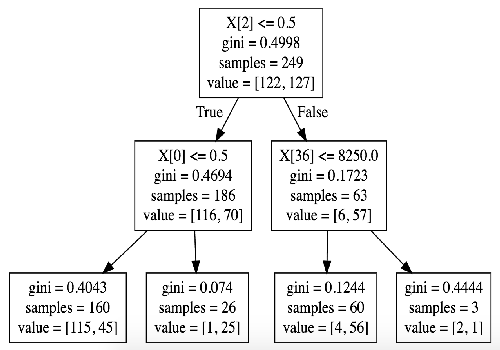

In [128]:
# visualize the decision tree
im = Image.open("model1.png")
im.resize((500,350), resample=0)

In [125]:
# separate out predictors and response variables on cleaned dataset without one hot
x_test = loan_test.iloc[:, :-1]
y_test = loan_test.iloc[:,-1]
x_train = loan_train.iloc[:, :-1]
y_train = loan_train.iloc[:,-1]

In [126]:
# fit a decision tree on non-one-hot data for comparison 
depth = 2
dt = tree.DecisionTreeClassifier(max_depth = depth)
model = dt.fit(x_train, y_train)
display_dt(model)
accuracy = dt.score(x_test, y_test)
print 'Accuracy of Tree Depth ', depth, ': ', accuracy

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4998\nsamples = 249\nvalue = [122, 127]"] ;
1 [label="X[2] <= 1.5\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.2563\nsamples = 53\nvalue = [8, 45]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 58\nvalue = [0, 58]"] ;
1 -> 3 ;
4 [label="X[0] <= 3822.0\ngini = 0.2873\nsamples = 138\nvalue = [114, 24]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.2055\nsamples = 129\nvalue = [114, 15]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 9\nvalue = [0, 9]"] ;
4 -> 6 ;
}
Accuracy of Tree Depth  2 :  0.880286069652


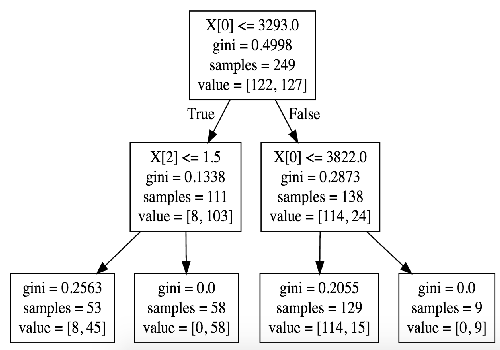

In [129]:
# visualize the new decision tree with clean predictors and no one-hot
im = Image.open("model2.png")
im.resize((500,350), resample=0)

In [30]:
# parse out census data and gender to remove discriminatory predictors
x_train_drop_1 = x_train.iloc[:, 1]
x_test_drop_1 = x_test.iloc[:, 1]
x_train_drop_2 = x_train.iloc[:, 3:]
x_test_drop_2 = x_test.iloc[:, 3:]
x_train_drop = pd.concat([x_train_drop_1, x_train_drop_2], axis = 1)
x_test_drop = pd.concat([x_test_drop_1, x_test_drop_2], axis = 1)

In [31]:
# fit a decision tree on fair predictors 
depth = 2
dt = tree.DecisionTreeClassifier(max_depth = depth)
model = dt.fit(x_train_drop, y_train)
display_dt(model)
accuracy = dt.score(x_test_drop, y_test)
print 'Accuracy of Tree Depth ', depth, ': ', accuracy

digraph Tree {
node [shape=box] ;
0 [label="X[4] <= 0.5\ngini = 0.4998\nsamples = 249\nvalue = [122, 127]"] ;
1 [label="X[19] <= 2902.5\ngini = 0.4645\nsamples = 169\nvalue = [107, 62]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.5\nsamples = 103\nvalue = [51, 52]"] ;
1 -> 2 ;
3 [label="gini = 0.2571\nsamples = 66\nvalue = [56, 10]"] ;
1 -> 3 ;
4 [label="X[7] <= 1.0\ngini = 0.3047\nsamples = 80\nvalue = [15, 65]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.4286\nsamples = 45\nvalue = [14, 31]"] ;
4 -> 5 ;
6 [label="gini = 0.0555\nsamples = 35\nvalue = [1, 34]"] ;
4 -> 6 ;
}
Accuracy of Tree Depth  2 :  0.606446932007


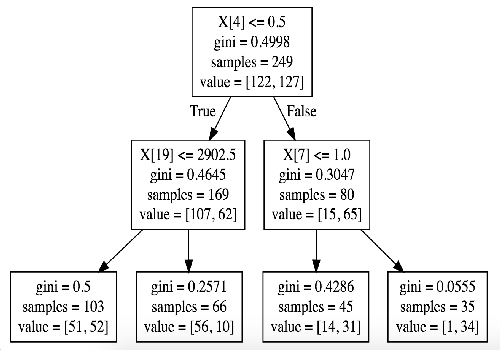

In [130]:
# visualize the new decision tree with fair, non-discriminatory predictors
im = Image.open("model3.png")
im.resize((500,350), resample=0)

I tested three different metrics:

-All data with one hot classification: 0. 758 accuracy

-All data without one hot classifcation: 0.880 accuracy

-Fair data only without one hot classification: 0.606 accuracy

Even though we are working with categorical variables, we do not need one hot encoding as it often lowers the prediction accuracy of our testing datasets. Decision trees have the ability to innately handle categorical variables and treat them as continuous variables. Therefore, encoding categorical variables as many binary variables can weaken the model as it is an unnecessary constraint. 

Furthermore, for dealing with real life people, 0.880 accuracy is very low for dealing with real people but would be even lower after excluding additional variables. The drop to 0.606 is a big drop in accuracy but it is ethically necessary. The initial data used a lot of discriminatory factors including gender and census data, which was strongly correlated with race. While race may have statistical correlations to other parameters, we do not want to use race data as it unfairly discriminates against minorities. Thus, if banks were to use this model, they may judge different races (ex. African American females) differently from Caucasian male loan seekers. 

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





In [65]:
# parse out predictors from response variables on clean data (no one hot)
x_train_drop_1 = x_train.iloc[:, 1]
x_test_drop_1 = x_test.iloc[:, 1]
x_train_drop_2 = x_train.iloc[:, 3:]
x_test_drop_2 = x_test.iloc[:, 3:]
x_train_drop = pd.concat([x_train_drop_1, x_train_drop_2], axis = 1)
x_test_drop = pd.concat([x_test_drop_1, x_test_drop_2], axis = 1)

In [66]:
# Initalize constants for bootstrap, use 3 for degrees as calculated above
num_samples = 60
model_array = []
depth = 2

# Perform bootstrap calculation to generate multiple y values
def boot_strap_r_squared(x_train, y_train, num_samples, degree):
    n = x_train.shape[0]
    
    for fold in range(0, num_samples):
        # Randomly a sample points from the train set of size 'n'
        indices = np.random.choice(np.arange(0, n), size=n)
        indices = list(indices)

        # obtain sample training sets with given indices
        x_train_sample = x_train.iloc[indices, :]
        y_train_sample = y_train.iloc[indices]

        # conduct polynomial regression fit and store y intercept
        dt = tree.DecisionTreeClassifier(max_depth = depth)
        model = dt.fit(x_train_sample, y_train_sample)
        model_array.append(model)
    return model_array
        
# Perform bootstrap on y values to obtain mean and standard deviation
model_array = boot_strap_r_squared(x_train_drop, y_train, num_samples, depth)

In [67]:
# chose a random decision tree and predict accuracy
model = random.choice(model_array)
display_dt(model)
accuracy = model.predict(x_test_drop)
print 'Random Classifer Accuracy: ', model.score(x_test_drop, y_test)

digraph Tree {
node [shape=box] ;
0 [label="X[4] <= 0.5\ngini = 0.4998\nsamples = 249\nvalue = [122, 127]"] ;
1 [label="X[19] <= 2902.5\ngini = 0.4645\nsamples = 169\nvalue = [107, 62]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.5\nsamples = 103\nvalue = [51, 52]"] ;
1 -> 2 ;
3 [label="gini = 0.2571\nsamples = 66\nvalue = [56, 10]"] ;
1 -> 3 ;
4 [label="X[7] <= 1.0\ngini = 0.3047\nsamples = 80\nvalue = [15, 65]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.4286\nsamples = 45\nvalue = [14, 31]"] ;
4 -> 5 ;
6 [label="gini = 0.0555\nsamples = 35\nvalue = [1, 34]"] ;
4 -> 6 ;
}
Random Classifer Accuracy:  0.601575456053


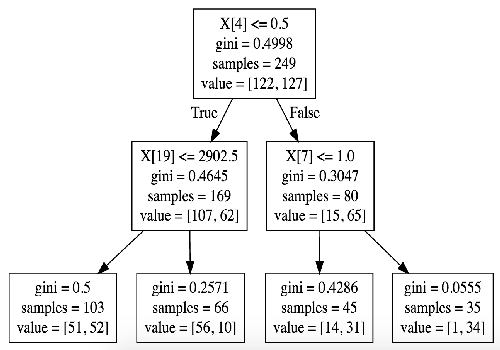

In [131]:
# visualize the random classifer selected tree
im = Image.open("model4.png")
im.resize((500,350), resample=0)

In [52]:
# majority vote classifier by accumulating votes
predict_array = []
for each in model_array:
    
    # append model accuracy to array
    model = random.choice(model_array)
    prediction = model.predict(x_test_drop)
    predict_array.append(prediction)
    
# normalize prediction outcomes between 0 and 1 by dividing by the total number
total = len(predict_array)
sum_column = np.sum(predict_array, axis=0)
decimals = [x / total for x in sum_column]

In [53]:
# categorize predictors by having values less than 0.5 be 0.0 and greater than 0.5 be 1.0
y_test_new = []
for each in decimals:
    if each <= 0.5:
        y_test_new.append(0.0)
    else:
        y_test_new.append(1.0)
print 'Multiple Classifier Accuracy: ', np.mean(np.array(y_test_new) == np.array(y_test))

Multiple Classifier Accuracy:  0.642412935323


In [72]:
# optimize accuracy by comparing predictors through a grid search
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

# find best parameters by optimizing parameters before finding accuracy   
def do_classify(clf, parameters, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    if parameters:
        clf = cv_optimize(clf, parameters, x_train_drop, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(x_train_drop, y_train)
    
    # calculate training and testing accuracy to print
    training_accuracy = clf.score(x_train_drop, y_train)
    test_accuracy = clf.score(x_test_drop, y_test)
    print "############# based on optimization ################"
    print "Accuracy on training data: %f" % (training_accuracy)
    print "Accuracy on test data:     %f" % (test_accuracy)
    print confusion_matrix(y_test, clf.predict(x_test_drop))
    print "########################################################"
    return clf, x_train_drop, y_train, x_test_drop, y_test

In [69]:
# initalize random forest classifer
clfForest = RandomForestClassifier(oob_score=True, max_features = 'auto')

# FIT THE TREE 
clf=clfForest.fit(x_train_drop, y_train)

# calculate training and testing accuracy to print
training_accuracy = clfForest.score(x_train_drop, y_train)
test_accuracy = clfForest.score(x_test_drop, y_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %f" % (training_accuracy)
print "Accuracy on test data:     %f" % (test_accuracy)
print confusion_matrix(y_test, clf.predict(x_test_drop))
print "########################################################"

# print parameters selected or default
print 'Number of Trees before Optimization: ', clfForest.n_estimators
print 'Depth before Optimization: ', clfForest.max_depth
print 'Max Features before Optimization: ', clfForest.max_depth

############# based on standard predict ################
Accuracy on training data: 0.983936
Accuracy on test data:     0.650290
[[3184 1599]
 [1775 3090]]
########################################################
Number of Trees before Optimization:  10
Depth before Optimization:  None
Max Features before Optimization:  None


In [75]:
# test three parameters: the number of trees, depth of each tree, and number of features
parameters = {"n_estimators": range(1, 20), "max_depth": range(1,10), "max_features": range(1,10)}

clfForest, x_train, y_train, x_test, y_test = do_classify(clfForest, parameters, 
                                                       n_jobs = 4, score_func='f1')

# print optimized parameters selected
print 'Number of trees: ', clfForest.n_estimators
print 'Optimized Tree Depth: ', clfForest.max_depth
print 'Max Features: ', clfForest.max_features

/Users/Christine/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


############# based on optimization ################
Accuracy on training data: 0.843373
Accuracy on test data:     0.663661
[[2883 1900]
 [1345 3520]]
########################################################
Number of trees:  16
Optimized Tree Depth:  4
Max Features:  5


The three different styles of prediction all generated an accuracy range within the same ballpark but random forests was the most accurate model, followed by majority vote, and lastly random selection. 

Random selection: 0.6016

Multiple classifier: 0.6424

Random forest before tuning: 0.6503

Random forest after tuning: 0.6637

These accuracy scores are compatible with our intutition. Random selection has the lowest accuracy because the results are still dependent on a single model, which means that there could be overfitting to the dataset that lowers the accuracy of classification. Multiple classifer is more accurate than random selection because it accumulates the results from multiple datasets through votes. This allows us to take the input of dozens of model and by averaging out the final classification, we reduce bias from a single model overfitting. Random forest classification is the most accurate measurement by fitting on random subsets of the larger tree through bootstrap. However, since random forest is also subject to overfitting, we need to adjust parameters to find the maximum accuracy and best holistic model. 

Random forest tuning was done on three parameters using gridsearch to compare multiple parameters spanning multiple values. I varied the maximum depth of a tree, the number of trees, and the number of predictors to prevent overfitting and optimize accuracy on the testing set. The depth of the tree influences the sensitivity of our model, the number of trees prevents overfitting by averaging over multiple trees, and the number of parameters varies the influence of each individual parameter as we can select more for greater sensitivity or fewer to prevent overfitting. After optimization of these parameters, the accuracy of random forest after tuning increased, which agrees with our intuition.

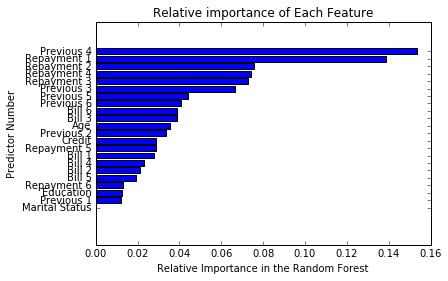

In [76]:
# find most important features and rank in order
importance_list = clfForest.feature_importances_
name_list = x_train_drop.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))

# plot the influence of predicts in order with relative importance
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Predictor Number')
plt.title('Relative importance of Each Feature')
plt.show()

In [77]:
# plot a heat map of the influence of predictors on final outcome
def plot_decision_surface(clf, x_train, y_train):
    plot_step=0.1
    
    if x_train.shape[1] != 2:
        raise ValueError("x_train should have exactly 2 columnns!")
    
    # identify and plot boundaries of the heatmap 
    x_min, x_max = x_train[:, 0].min() - plot_step, x_train[:, 0].max() + plot_step
    y_min, y_max = x_train[:, 1].min() - plot_step, x_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # fit the data to the random forest classifier model
    clf.fit(x_train, y_train)
    
    # predict the probability of generating response and shade the map accordingly
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(x_train[:,0],x_train[:,1],c= y_train,cmap=plt.cm.Paired)
    plt.show()

In [78]:
# fit random forests on 2 varying parameters to visualize
clfForest_1 = RandomForestClassifier(oob_score=True, max_features = 'auto')
clfForest_1 = clfForest_1.fit(x_train_drop, y_train)
parameters = {"n_estimators": range(1, 20), "max_depth": range(1,10)}
clfForest_1, x_train, y_train, x_test, y_test = do_classify(clfForest_1, parameters, 
                                                       n_jobs = 4, score_func='f1')
# find most important features to plot on a heat map
imp_cols = clfForest_1.feature_importances_.argsort()[::-1][0:2]

############# based on optimization ################
Accuracy on training data: 0.907631
Accuracy on test data:     0.666148
[[3100 1683]
 [1538 3327]]
########################################################


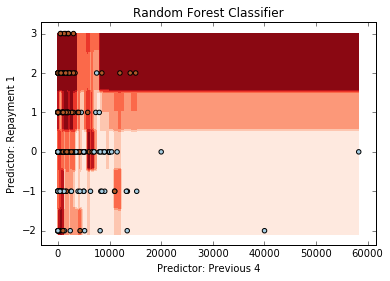

In [79]:
# isolate most important predictors to plot
X_imp = x_train_drop[imp_cols].values
Y = y_train.values

classifiers = [clfForest_1]
titleClassifer = ['Random Forest Classifier'] 

# plot demonstration of how predictors influence the final response (either 1.0 or 0.0)
for c in xrange(1):
    plt.title(titleClassifer[c])
    plt.xlabel("Predictor: " + str(x_train_drop[imp_cols].columns[0]))
    plt.ylabel("Predictor: " + str(x_train_drop[imp_cols].columns[1]))
    plot_decision_surface(classifiers[c], X_imp, y_train.values)

Random forest selected 5 predictors as optimal. This agrees with the mathematical intuition as the optimal number of predictors is p^0.5 and with p = 24, p^0.5 = 4.9 (approximately equal to 5). We can also see from the graph of the relative importance of each predictor that there are a few (previous 4, repayments, etc.) that are extremely informative and the rest of the predictors decrease in their relative contribution to the final prediction outcome. 

However, in the plot above of the two predictors, we see that while many points are classified correctly just on the two main predictors alone, there are also many that are still incorrectly classified, especially if they are surrounded by clusters of the other response variable. Therefore, while the two main predictors are informative, we need more predictors (5) to have the highest accuracy and classify correctly the more detailed nodes. 5 predictors strikes a good balance as using a number of parameters greater than five opens up the risk of overfitting. 

## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [44]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        print 'Test case', i, ':', fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2)    